<h1>ALA 470 Final Project</h1>

<p>By Haley Johnson</p>

In [2]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [55]:
sns.set_style("dark")
sns.color_palette("Paired")
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Load Data</h2>

In [3]:
df = pd.read_csv("fake.csv")

In [101]:
df.shape

(12999, 30)

In [4]:
with open('stopwords.txt') as s:
    stopwords = s.read()

In [5]:
stopwords = stopwords.split(" ")

<h2>Preprocess</h2>

<h3>Tokenize</h3>

In [79]:
df['text'] = df['text'].astype(str)
df['text_normalized'] = df['text'].str.lower()
df['sentences'] = df['text_normalized'].apply(lambda s: [sent for sent in nltk.sent_tokenize(s)])
df['tokens'] = df['text_normalized'].apply(lambda t: [word for sent in nltk.sent_tokenize(t) for word in nltk.word_tokenize(sent)])

In [8]:
df['title'] = df['title'].astype(str)
df['title_normalized'] = df['title'].str.lower()
df['title_tokens'] = df['title_normalized'].apply(nltk.word_tokenize)

In [9]:
df['non_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if w not in stopwords])
df['non_stopwords_count'] = df['non_stopwords'].apply(len)

In [10]:
df['title_no_stopwords'] = df['title_tokens'].apply(lambda t: [w for w in t if w not in stopwords])

<h2>Basic Text Exploration</h2>

In [78]:
targets = ['hillary clinton', 'bill clinton', 'donald trump', 'nancy pelosi', 'global warming', 'vaccines', 
           'democrat', 'republican', 'main stream media', 'washington d.c.']

for target in targets:
    res = df['text_normalized'].str.match(target)
    print(f"There are {res.sum()} mentions of '{target}'\n")

There are 43 mentions of 'hillary clinton'

There are 6 mentions of 'bill clinton'

There are 36 mentions of 'donald trump'

There are 0 mentions of 'nancy pelosi'

There are 0 mentions of 'global warming'

There are 1 mentions of 'vaccines'

There are 11 mentions of 'democrat'

There are 6 mentions of 'republican'

There are 0 mentions of 'main stream media'

There are 1 mentions of 'washington d.c.'



In [ ]:
sentences_lst = df['sentences'].to_list()
count = 0

for sentences in sentences_lst:
    for s in sentences:
        if re.match(r'\bhillary clinton\b', s):
            count += 1

<h2>NLTK</h2>

<h3>Top Tokens by Type</h3>

In [11]:
types = list(df['type'].unique())

In [12]:
top_tokens = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded_tokens = matches.explode('non_stopwords')
    exploded_tokens = exploded_tokens[pd.isnull(exploded_tokens['non_stopwords']) == False]
    top_tokens.append(exploded_tokens['non_stopwords'].value_counts())

<h3>Filter Out Puncutation Tokens</h3>

In [13]:
punctuation = ["'", "'", '"', '"', ".", "?", ",", "!", "-", ",", ".", '”', '“', ";", ":", "(", ")", "’",
               '–', "&", '``', "''", "'s", "...", ":", "@", "‘"]

In [14]:
for i in range(len(top_tokens)):
    current = top_tokens[i].reset_index().rename(columns = {'index': 'token', 'non_stopwords': 'count'} )
    current = current[current['token'].apply(lambda s: s not in punctuation) == True]
    top_tokens[i] = current

<h2>Visualize Tokens</h2>

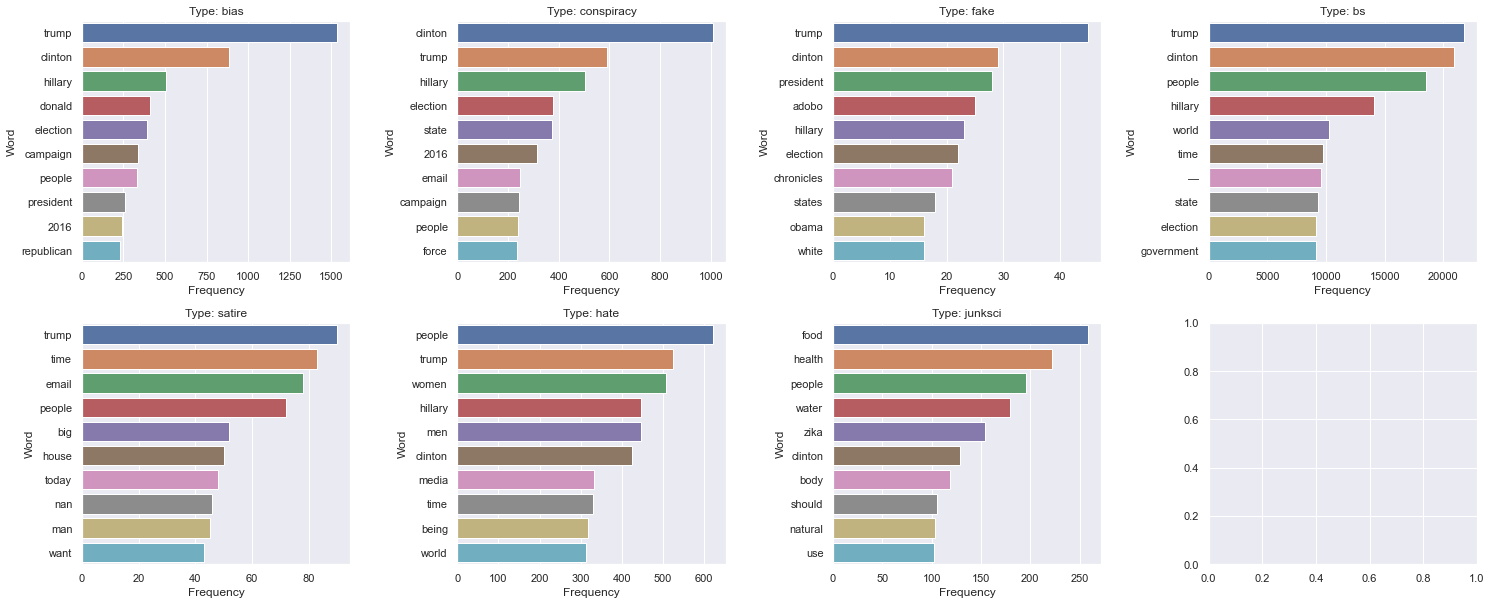

In [56]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    top = top_tokens[i].sort_values(by = 'count', ascending = False)[:10]
    grid = sns.barplot(x = top['count'], y = top['token'], ax = ax)
    grid.set(title = f"Type: {types[i]}", xlabel = 'Frequency', ylabel = 'Word')
    

<h3>Named Entity Recognition</h3>

In [103]:
df.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type',
       'text_normalized', 'tokens', 'title_normalized', 'title_tokens',
       'non_stopwords', 'non_stopwords_count', 'title_no_stopwords',
       'entities', 'title_entities', 'sentences'],
      dtype='object')

In [146]:
def get_entity_types(s):
    '''
    Takes in a text field, 
    uses NLTK named entity
    recongition to determine
    how many entities there
    are of each type
    '''
    entities_dict = {}
    entities_dict['type'] = s['type']
    text = str(s['text_normalized'])
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        label = entity.label()
        for leaf in entity.leaves():
            entities_dict[label] = entities_dict.get(label, 0) + 1
    return entities_dict
        

In [147]:
tags = df.apply(get_entity_types, axis = 1)

In [148]:
temp = pd.DataFrame(tags)
by_entity = temp[0].apply(pd.Series)
by_entity = by_entity.fillna(value = 0)

In [57]:
def get_target_entities(s):
    '''
    Takes in a text fielld
    
    Returns all the entities 
    matching the labels in the
    targets list
    '''
    items = []
    s = str(s)
    tokens = [word for sent in nltk.sent_tokenize(s) for word in nltk.word_tokenize(sent)]
    targets = ['PERSON', 'GPE', 'ORGANIZATION', 'FACILITY', 'NORP', 'ORG', 
               'LOC', 'EVENT', 'LAW']
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)

    for entity in entities.subtrees():
        if entity.label() == "PERSON":
            name = []
            for leaf in entity.leaves():
                name.append(leaf[0])
            items.append(" ".join(name))
    return items

In [58]:
df['entities'] = df['non_stopwords'].apply(get_target_entities)

<h4>NER On Title</h4>

In [59]:
df['title_entities'] = df['title_no_stopwords'].apply(get_target_entities)

<h2>Visualize Top Entities</h2>

<h3>Text</h3>

In [60]:
top = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('entities')
    exploded = exploded[pd.isnull(exploded['entities']) == False]
    exploded['entities'] = exploded['entities'].apply(lambda s: s[1:])
    top.append(exploded['entities'].value_counts())

In [61]:
fake = top[2]
top = top[:2] + top[3:]

Text(0.5, 0.98, 'Most Common Entities in Fake News Articles')

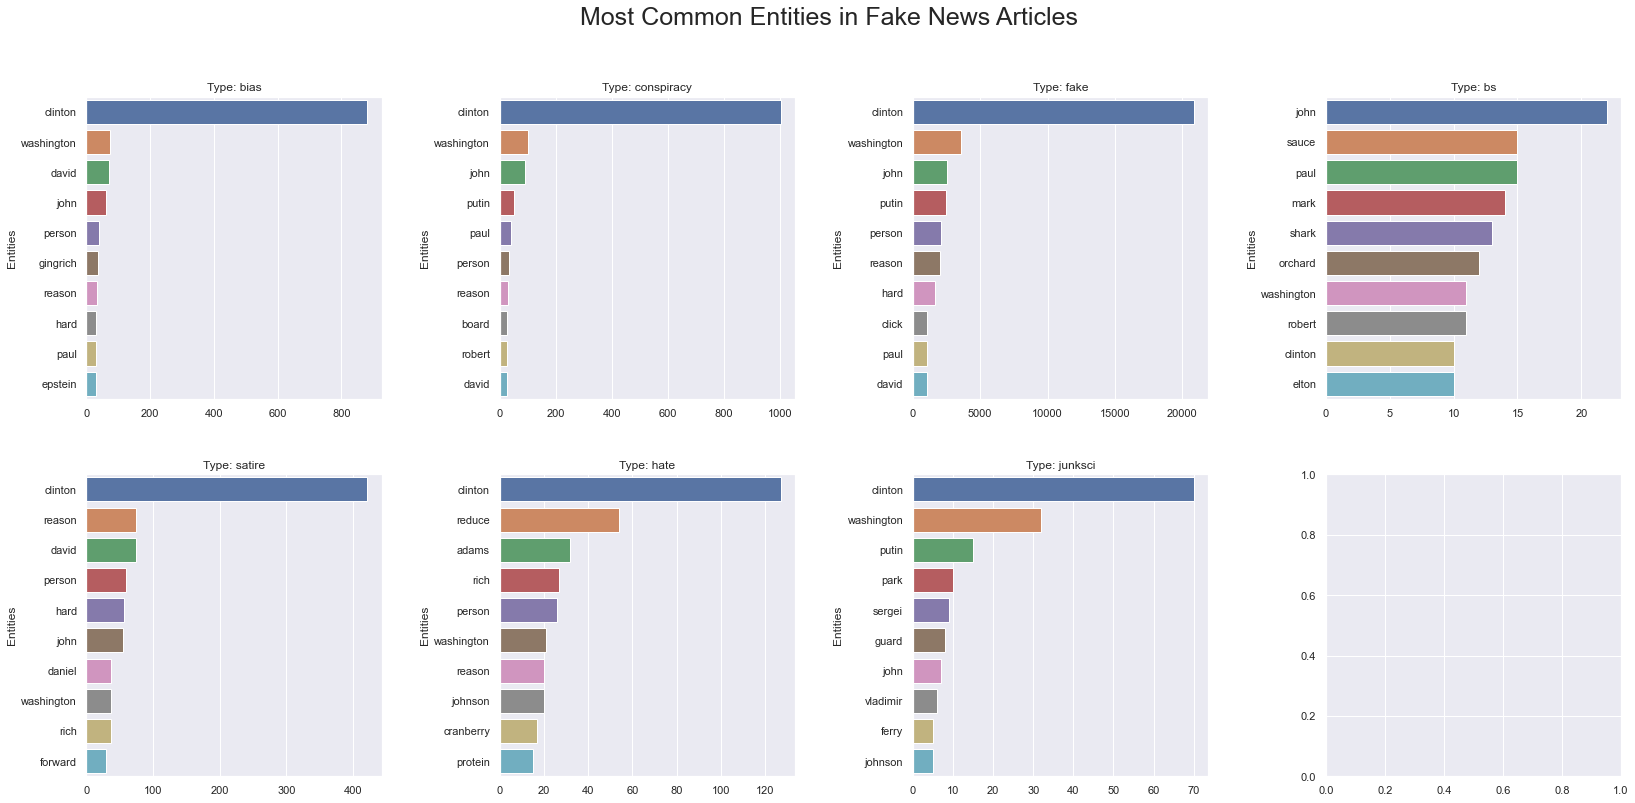

In [62]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(27.5, 12.5)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Fake News Articles", fontsize = 25)

<h3>Title</h3>

In [47]:
top_ners = []
for i in range(len(types)):
    matches = df[df['type'] == types[i]]
    exploded = matches.explode('title_entities')
    exploded = exploded[pd.isnull(exploded['title_entities']) == False]
    exploded['title_entities'] = exploded['title_entities'].apply(lambda s: s[1:])
    top_ners.append(exploded['title_entities'].value_counts())

Text(0.5, 0.98, 'Most Common Entities in Titles of Fake News Articles')

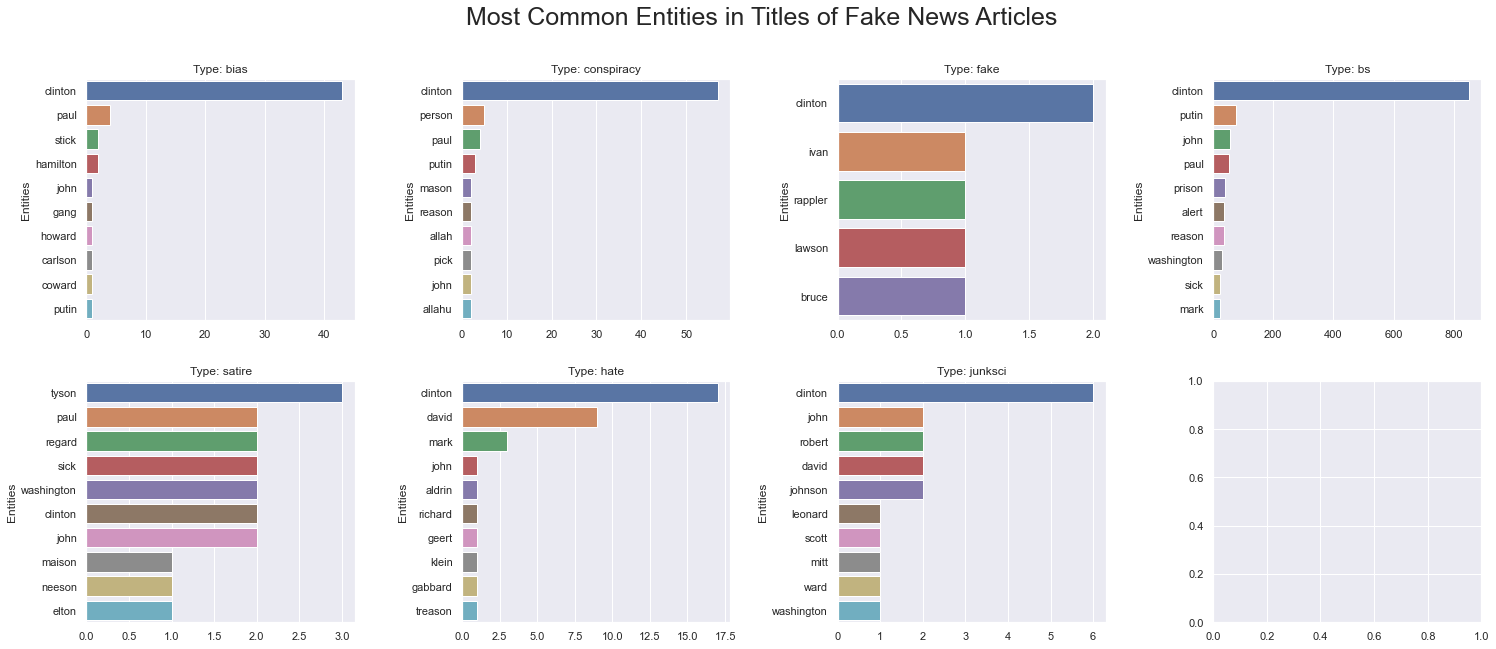

In [48]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    top_subset = top_ners[i][:10]
    grid = sns.barplot(x = top_subset.values, y = top_subset.index, ax = ax)
    grid.set(ylabel = 'Entities', title = f"Type: {t}")
    
fig.suptitle("Most Common Entities in Titles of Fake News Articles", fontsize = 25)

<h3>By Entity Type</h3>

In [150]:
fig_df = by_entity[by_entity['type'] == t]

In [151]:
fig_df

,type,S,GPE,PERSON,ORGANIZATION,GSP
0,bias,97.0,0.0,0.0,0.0,0.0
1,bias,322.0,0.0,0.0,0.0,0.0
2,bias,265.0,0.0,0.0,0.0,0.0
3,bias,51.0,0.0,0.0,0.0,0.0
4,bias,367.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
12691,bias,142.0,0.0,0.0,0.0,0.0
12692,bias,137.0,0.0,0.0,0.0,0.0
12693,bias,119.0,0.0,0.0,0.0,0.0
12694,bias,208.0,0.0,0.0,0.0,0.0


In [ ]:
sns.barplot(x  )

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

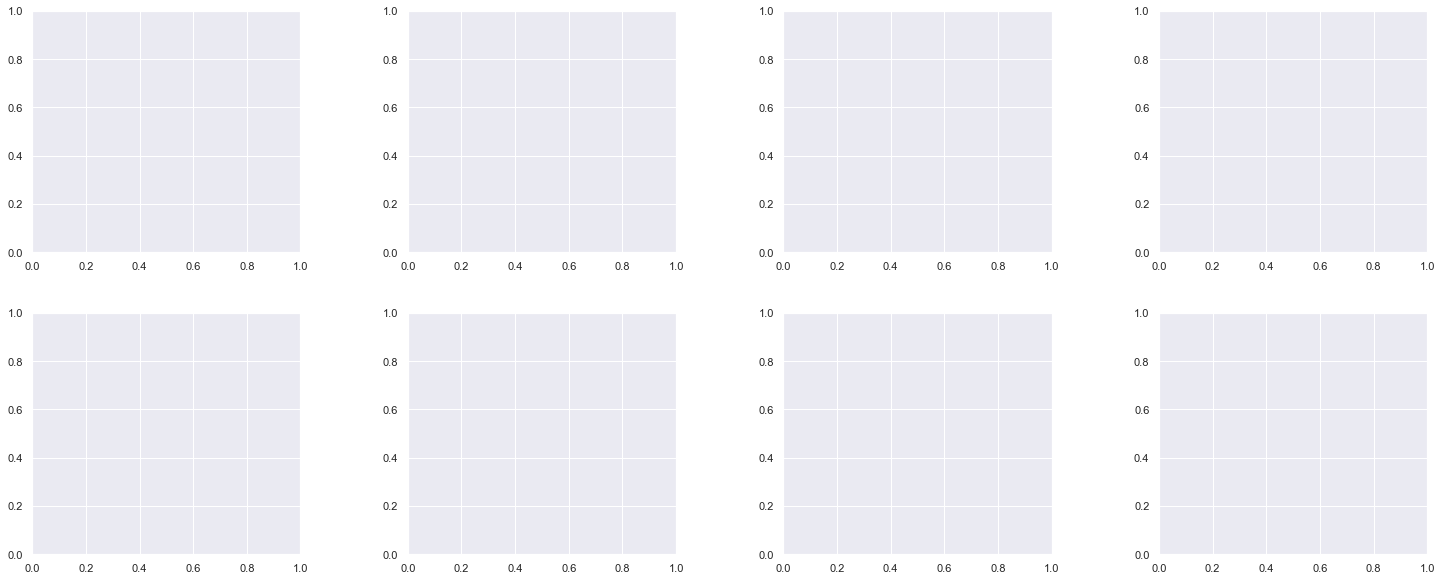

In [142]:
# placeholder
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
fig.subplots_adjust(hspace = 0.25, wspace = 0.4)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        break
    t = types[i]
    fig_df = by_entity[by_entity['type'] == t]
    grid = sns.barplot(x = fig_df.iloc[:, 1:], y = fig_df.iloc[:, 0], ax = ax)
    

In [141]:
by_entity.iloc[:, 0]

0        bias
1        bias
2        bias
3        bias
4        bias
         ... 
12994      bs
12995      bs
12996      bs
12997      bs
12998      bs
Name: type, Length: 12999, dtype: object